<a href="https://colab.research.google.com/github/gibranfp/CursoDatosMasivosI/blob/main/notebooks/4c_streaming_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. *Streaming* con *PySpark*

En este notebook hacemos una introduccion a *Spark Streaming* usando la API de *Spark* para *Python* llamada *PySpark*.
               
## 5.1 Introduccion a *Spark Streaming*

*Spark Streaming* es una extension de *Spark* que nos permite procesar flujos de datos en tiempo real con todas las ventajas que nos proporciona *Spark*, tales como escalabilidad, computo distribuido en *clusters*, etc.

Conceptualmente, lo que hace *Spark Streaming* es lo siguiente. Recibe un flujo de datos en tiempo real, dependiendo de la $\Delta t$ proporcionada, este dividira al flujo en *batches* (lotes en espanol), los cuales posteriormente se podran manipular como *RDD*s normales.

El objeto de alto nivel que proporciona *Spark Streaming* para manejar los *batches* antes mencionados es conocido como *DStream* (discretized stream). Un *DStream* no es mas que una secuencia de *RDD*s ordenados en el tiempo, donde cada *RDD* contiene los datos recibidos en un intervalo de tiempo determinado.

De esta forma, *Spark* puede procesar los datos sin saber que lo que esta recibiendo realmente es un flujo de datos, puesto que el *DStream* se encarga de crear y administrar los *RDD*s. 

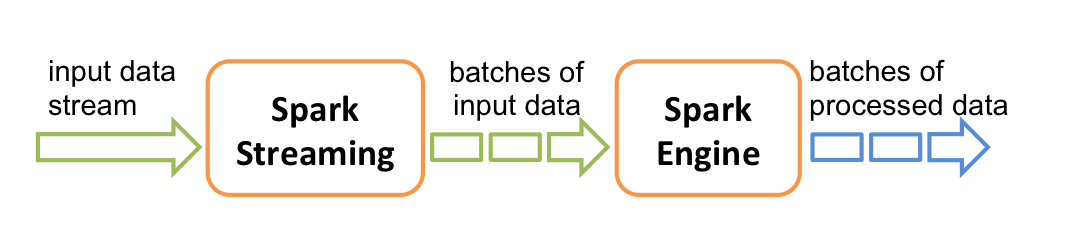

## 5.2 Ejemplo de juguete

En esta seccion planetaremos un ejemplo muy sencillo para poder familiarizarnos con las funcionalidades basicas de *Spark Streaming*.

Antes de hacer cualquier cosa, debemos instalar nuestro entorno de desarrollo con `PySpark`

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 75kB/s 
     |████████████████████████████████| 204kB 16.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=37974a1da49d15341328286504d393f6a3ce577a95c9a9cd6662ad22ed56ed33
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this 

### 5.2.1 Creando un *StreamingContext*

Antes que nada llamemos a las siguientes bibliotecas


In [93]:
# Cosas importantes de pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import size

# Extras
from operator import add, sub
from time import sleep
import numpy as np
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

A diferencia de ejemplos anteriores, donde el punto de partida para usar `pyspark` era un objeto de la clase `SparkSession` (la cual es relativamente reciente), para iniciar un programa de *streaming* con `pyspark` necesitamos crear un objeto de la clase `SparkContext` (que en comparacion a un `SparkSession` es de mas bajo nivel, pero a partir del cual se puede crear RDDs) y a partir de este crear un `StramingContext`

In [3]:
# Crea un SparkContext
sc = SparkContext.getOrCreate()

# Crea un StreamingContext
delta_t = 1 # en segundos
ssc = StreamingContext(sc, delta_t)

### 5.2.2 Datos de juguete

Obviamente, para hacer un ejemplo necesitamos datos. Simularemos un flujo de datos de la siguiente manera. Primero crearemos los *batches* de forma artificial usando `numpy`


In [4]:
# Para poder reproducir los datos
np.random.seed(182)

batches = []

# Generamos batches con numeros aleatorios
for i in range(100):
  batch_size = np.random.randint(1, 10)
  batch = np.random.randint(1, 10, size = batch_size)
  batches.append(list(batch))

batches[: 5]

[[3, 3, 3, 6, 9, 9, 8, 3, 8],
 [2, 3, 4, 2, 7, 1, 7, 7],
 [2, 5, 4, 4, 7, 4, 6, 9, 4],
 [9, 3, 5, 7, 4, 2, 1, 1, 8],
 [2, 5, 4, 8, 9]]

para simular que estos *batches* provienen de un flujo de datos usamos debemos hacer lo siguiente

In [5]:
cola_rdds = []

# Transformamos cada batch en un rdd
for batch in batches:
  rdd_batch = sc.parallelize(batch)
  cola_rdds.append(rdd_batch)

Supongamos ahora que tenemos un flujo, para poder ver que forma tienen los datos podriamos hacer algo como esto

In [6]:
# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Especificamos el procesamiento
flujo_datos.pprint()

# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(3)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 02:39:52
-------------------------------------------
3
3
3
6
9
9
8
3
8

-------------------------------------------
Time: 2021-05-13 02:39:53
-------------------------------------------
2
3
4
2
7
1
7
7

-------------------------------------------
Time: 2021-05-13 02:39:54
-------------------------------------------
2
5
4
4
7
4
6
9
4



La funcion `.pprint()` pertenece a un conjunto de funciones llamadas *Output Operations*, las cuales sirven para sacar los datos de los *DStream*s y pasarlos a una base de datos o archivos. Para mas informacion por favor consulte la [documentacion](https://spark.apache.org/docs/latest/streaming-programming-guide.html) de *Spark Streaming*.

### 5.2.3 Transformaciones sobre *DStream*s

Muchas de las transformaciones para los *RDD*s tienen su contraparte para los *DStream*s. Un ejemplo seria la funcion `count()`, la que usamos a continuacion para contar cuantos elementos existen en cada *batch*, o visto de otra forma, cuantos datos se recibieron por intervalo de tiempo





In [7]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Especificamos el procesamiento
flujo_datos.count() \
           .pprint()

# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 02:39:56
-------------------------------------------
9

-------------------------------------------
Time: 2021-05-13 02:39:57
-------------------------------------------
8

-------------------------------------------
Time: 2021-05-13 02:39:58
-------------------------------------------
9

-------------------------------------------
Time: 2021-05-13 02:39:59
-------------------------------------------
9

-------------------------------------------
Time: 2021-05-13 02:40:00
-------------------------------------------
5



Otro ejemplo seria aplicar funciones a la suma de los datos de cada batch

In [14]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Especificamos el procesamiento
flujo_datos.reduce(lambda x, y: x + y) \
           .map(lambda x: x**2) \
           .pprint()

# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 03:21:14
-------------------------------------------
2704

-------------------------------------------
Time: 2021-05-13 03:21:15
-------------------------------------------
1089

-------------------------------------------
Time: 2021-05-13 03:21:16
-------------------------------------------
2025

-------------------------------------------
Time: 2021-05-13 03:21:17
-------------------------------------------
1600

-------------------------------------------
Time: 2021-05-13 03:21:18
-------------------------------------------
784



### 5.2.4 Algunas transformaciones importantes

Existen un par de transfromaciones a las cuales vale la pena prestarles un poco mas de atencion.

#### 5.2.4.1 `UpdateStateByKey`

Esta funcion nos permite monitorear alguna cantidad basada en las llaves de los datos `(llave, valor)`. Para hacer esto debemos definir una funcion que nos permita actualizar la cantidad deseada dados los nuevos valores contenidos en el batch entrante. 

Para hacer un ejemplo primero debemos tranformar los datos del flujo en pares `(llave, valor)`

In [35]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Procesamiento
pares = flujo_datos.map(lambda x: (x, 1)) 

pares.pprint()

# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 04:06:04
-------------------------------------------
(3, 1)
(3, 1)
(3, 1)
(6, 1)
(9, 1)
(9, 1)
(8, 1)
(3, 1)
(8, 1)

-------------------------------------------
Time: 2021-05-13 04:06:05
-------------------------------------------
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(7, 1)
(1, 1)
(7, 1)
(7, 1)

-------------------------------------------
Time: 2021-05-13 04:06:06
-------------------------------------------
(2, 1)
(5, 1)
(4, 1)
(4, 1)
(7, 1)
(4, 1)
(6, 1)
(9, 1)
(4, 1)

-------------------------------------------
Time: 2021-05-13 04:06:07
-------------------------------------------
(9, 1)
(3, 1)
(5, 1)
(7, 1)
(4, 1)
(2, 1)
(1, 1)
(1, 1)
(8, 1)

-------------------------------------------
Time: 2021-05-13 04:06:08
-------------------------------------------
(2, 1)
(5, 1)
(4, 1)
(8, 1)
(9, 1)



Si quisieramos monitorear cuantas veces aparece cada valor durante el flujo de datos debemos hacer lo siguiente

In [34]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)
# Para usar updateStateByKey es necesario crear un checkpoint
ssc.checkpoint("checkpoint")

# Funcion que nos dice como actualizar el valor acumulado
def actualiza_conteo(valores_nuevos, valor_acumulado):
  
  # Si aun no ha aparecido la llave
  if valor_acumulado is None:
    valor_acumulado = 0

  # Actualiza (valores_nuevos es una lista)
  nuevo_valor = sum(valores_nuevos) + valor_acumulado

  return nuevo_valor

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Procesamiento
conteo_datos = flujo_datos.map(lambda x: (x, 1)) \
                          .updateStateByKey(actualiza_conteo)

conteo_datos.pprint()       
                          
# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 03:44:25
-------------------------------------------
(6, 1)
(8, 2)
(3, 4)
(9, 2)

-------------------------------------------
Time: 2021-05-13 03:44:26
-------------------------------------------
(6, 1)
(8, 2)
(2, 2)
(4, 1)
(3, 5)
(9, 2)
(7, 3)
(1, 1)

-------------------------------------------
Time: 2021-05-13 03:44:27
-------------------------------------------
(6, 2)
(8, 2)
(2, 3)
(4, 5)
(3, 5)
(9, 3)
(7, 4)
(1, 1)
(5, 1)

-------------------------------------------
Time: 2021-05-13 03:44:28
-------------------------------------------
(6, 2)
(8, 3)
(2, 4)
(4, 6)
(3, 6)
(9, 4)
(7, 5)
(1, 3)
(5, 2)

-------------------------------------------
Time: 2021-05-13 03:44:29
-------------------------------------------
(6, 2)
(8, 4)
(2, 5)
(4, 7)
(3, 6)
(9, 5)
(7, 5)
(1, 3)
(5, 3)



No es el proposito de esta leccion explicar que es un checkpoit, sin em abro el lector curioso puede referirse [aqui](https://spark.apache.org/docs/latest/streaming-programming-guide.html#checkpointing) .


#### *5.2.4.2* La operacion `transform`

Aunque muchas de las funciones para *RDD*s estan disponibles tambien para *DStream*s, existen sus excepciones. En el caso que quisieramos emplear una funcion disponible para *RDD*s y no para *DStream*s podemos usar la funcion `transform`.

Un ejemplo de este tipo de funciones es la funcion `join()`, podemos aplicar esta funcion sobre los batches de un *DStream* de la siguiente manera

In [41]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Creamos datos para ejemplo con .join
otros_datos = sc.parallelize([(2, 1), (5, 9)])

# Procesamiento
nuevo_flujo = flujo_datos.transform(lambda rdd: rdd.map(lambda x: (x, 1)).join(otros_datos))

nuevo_flujo.pprint()       
                          
# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 04:30:51
-------------------------------------------

-------------------------------------------
Time: 2021-05-13 04:30:52
-------------------------------------------
(2, (1, 1))
(2, (1, 1))

-------------------------------------------
Time: 2021-05-13 04:30:53
-------------------------------------------
(5, (1, 9))
(2, (1, 1))

-------------------------------------------
Time: 2021-05-13 04:30:54
-------------------------------------------
(5, (1, 9))
(2, (1, 1))

-------------------------------------------
Time: 2021-05-13 04:30:55
-------------------------------------------
(5, (1, 9))
(2, (1, 1))



**NOTA: Los DStreams si cuentan con una funcion .join(), sin embargo su funcionalidad es diferente a la presentada en este ejemplo. Es decir, no podemos reproducir estos resultados con dicha funcion.**

#### 5.2.4.3 Las opreaciones con ventanas

Las funciones con ventanas nos permite efectuar operaciones por ventanas que se deslizan a traves del en el flujo de datos. Cuando la ventana pasa a traves del flujo se genera otro flujo cuyos *RDD*s son resultado de la combinacion de los *RDD*s que caen dentro de las ventanas.

Para usar estas funciones es necesario especificar dos hiperparametros:

* El tamaño de la ventana: La duracion en el tiempo de la ventana. 
* El tamaño del deslizamiento: Intervalo en el cual la opreacion con ventana sera ejecutada.

Ambos parametros deben ser multiplos del $\Delta t$ con el cual fue creado el *DStream* original.



Por ejemplo, en la siguiente figuar $\Delta t = 1$, el tamaño de la ventana es 3 y el tamaño del deslizamiento es 2.

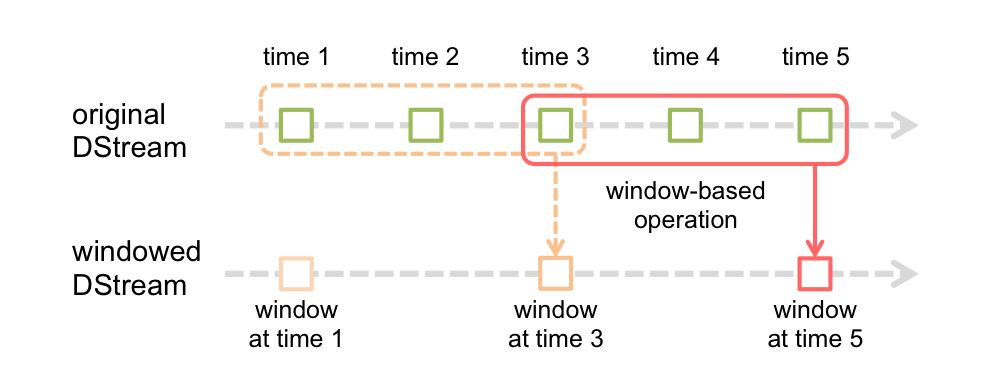

Por ejemplo, en nuestro flujo de juguete, podemos querer calcular la suma de todos elementos en una ventana de tamaño 4 y tamaño de deslizamiento 1

In [47]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_datos = ssc.queueStream(cola_rdds)

# Procesamiento
conteo_ventana = flujo_datos.reduceByWindow(lambda x, y: x + y, lambda x, y: x - y, 4, 1)
conteo_ventana.pprint()
                          
# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(5)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 06:41:33
-------------------------------------------
52

-------------------------------------------
Time: 2021-05-13 06:41:34
-------------------------------------------
85

-------------------------------------------
Time: 2021-05-13 06:41:35
-------------------------------------------
130

-------------------------------------------
Time: 2021-05-13 06:41:36
-------------------------------------------
170

-------------------------------------------
Time: 2021-05-13 06:41:37
-------------------------------------------
146



Para conocer mas funciones con ventanas por favor dirijase [aqui](https://spark.apache.org/docs/latest/api/python/reference/pyspark.streaming.html)

## 5.3 Un ejemplo *mas real*

Simularemos que recibimos los dialogos de Rick y Morty en un flujo de datos. El siguiente codigo solo extrae las lineas y las junta en una lista

In [73]:
# Lee el texto
datos_rym_crudos = open('/content/RickAndMortyScripts.csv', 'r')

datos_rym_lista = []

for linea in datos_rym_crudos:
  # Separa por las comas
  linea = linea.split(',')
  # Toma el dialogo y quita el salto de linea
  linea = linea[-1].replace('\n', '')
  # Guarda el dialogo
  datos_rym_lista.append(linea)

# Elimina el nombre de la columna
v = datos_rym_lista[1:]

Crea batches con los datos

In [75]:
batches_rym = []

while len(datos_rym_lista) > 100:
  batch_size = np.random.randint(50, 100)
  batch = datos_rym_lista[:batch_size]
  datos_rym_lista = datos_rym_lista[batch_size:]
  batches_rym.append(batch)
  
batches_rym.append(datos_rym_lista)

Si tuvieramos un flujo de datos de texto y tuvieramos que limpiarlo para poder analizarlo, deberiamos hacer lo siguiente

In [95]:
# Dado que ejecutamos ssc.stop() debemos crear un nuevo ssc
delta_t = 1
ssc = StreamingContext(sc, delta_t)

# Creamos el flujo de datos artificial
flujo_rym = ssc.queueStream(batches_rym)

# Definimos funcion para quitar palabras vacias
palabras_vacias = nltk.corpus.stopwords.words('english')

def quita_palabras_vacias(texto):
  texto_limpio = [ palabra for palabra in texto if palabra not in palabras_vacias ]
  return texto_limpio

# Limpieza de datos
flujo_limpio = flujo_rym.map(lambda dialogo: dialogo.lower()) \
                        .map(lambda dialogo: dialogo.translate(str.maketrans('', '', string.punctuation))) \
                        .map(lambda dialogo: dialogo.split(' ')) \
                        .map(lambda palabra: quita_palabras_vacias(palabra)) \
                        .flatMap(lambda x: x)

# Imprimimos solo los primeros dos elementos
flujo_limpio.pprint(2)
                          
# Inicializamos el analisis del flujo de datos
ssc.start()
sleep(10)
# Terminamos con TODO el proceso
ssc.stop(stopSparkContext = False)

-------------------------------------------
Time: 2021-05-13 07:36:22
-------------------------------------------
morty
gotta
...

-------------------------------------------
Time: 2021-05-13 07:36:23
-------------------------------------------
jejessica
jessica
...



## Ejercicio

1. Contar cuantas veces aparecen las palabras *rick* y *morty* de forma acumulada en el flujo.

2. Contar cuantas veces aparecen las palabras *rick* y *morty* en ventanas de 30 segundos, en intervalos de 4 segundos.